In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from dotenv import load_dotenv

sns.set_theme()

##### Set the current working directory to the root of your project
os.chdir("/Users/evan/Documents/School/MSDS/msds-capstone/vm-spinal-risk/vm-spinal-risk/")


from utilities import data_processing as dp_utils
from utilities import eda_tools as eda_utils

In [2]:
odi_df = pd.read_csv('./data/normative_odi_processed.csv')

In [3]:
odi_df.columns

Index(['record_id', 'age', 'sex', 'height', 'weight_in_pounds', 'zip_code',
       'occupation_demands', 'lbp', 'lbp_treatment', 'please_specify',
       'pain_intensity', 'personal_care_e_g_washing', 'lifting', 'walking',
       'sitting', 'standing', 'sleeping', 'social_life', 'travelling',
       'employment_homemaking', 'attention_check___1', 'attention_check___2',
       'attention_check___3', 'attention_check___4', 'attention_check___5',
       'attention_check___6',
       'assessment_of_back_pain_in_people_who_never_had_sp_complete',
       'height_m', 'weight_kg', 'bmi', 'age_range', 'odi_score', 'postal_code',
       'city', 'state', 'state_code', 'province', 'province_code', 'latitude',
       'longitude'],
      dtype='object')

In [4]:
list(odi_df.columns)[20:26]

['attention_check___1',
 'attention_check___2',
 'attention_check___3',
 'attention_check___4',
 'attention_check___5',
 'attention_check___6']

In [5]:
odi_df = dp_utils.filter_df_by_attention_check(odi_df, 20, 26, 4, remove=False)
odi_quality_df = odi_df[odi_df['pass_att_check'] == True]

85.37 percent of responses passed the attention check.


In [6]:
odi_quality_df.head()

,record_id,age,sex,height,weight_in_pounds,zip_code,occupation_demands,lbp,lbp_treatment,please_specify,...,odi_score,postal_code,city,state,state_code,province,province_code,latitude,longitude,pass_att_check
1,2,45,2,20,89,44107,2,1,1.0,NaN,...,20.0,44107.0,Lakewood,Ohio,OH,Cuyahoga,35.0,41.4847,-81.8018,True
3,4,69,2,23,46,59474,3,1,3.0,NaN,...,12.0,59474.0,Shelby,Montana,MT,Toole,101.0,48.5037,-111.8391,True
4,5,26,1,21,74,60647,1,1,3.0,NaN,...,10.0,60647.0,Chicago,Illinois,IL,Cook,31.0,41.9209,-87.7043,True
5,6,28,2,16,117,28584,1,1,1.0,NaN,...,12.0,28584.0,Swansboro,North Carolina,NC,Onslow,133.0,34.6991,-77.1350,True
6,7,29,2,16,10,12508,4,1,3.0,NaN,...,30.0,12508.0,Beacon,New York,NY,Dutchess,27.0,41.5097,-73.9634,True


In [34]:
from tableone import TableOne

## Create an instance of TableOne with the input arguments
columns = [
       'age',
       'sex', 
       'height_m', 
       'weight_kg', 
       'bmi',
       'lbp',
       # 'how_physically_demanding_i', 
       # 'have_you_ever_experienced',
       # 'how_have_you_addressed_add', 
       'age_range', 
       'odi_score']
nonnormal = ['odi_score', 'weight_kg', 'bmi']
categorical = ['age_range', 'sex', 'lbp']
mytable = TableOne(odi_quality_df, columns=columns, categorical=categorical, nonnormal=nonnormal)

mytable
## Display the table using the tabulate method. The tablefmt argument allows the table to be displayed in multiple formats, including “github”, “grid”, “fancy_grid”, “rst”, “html”, and “latex”.:
print(mytable.tabulate(tablefmt="github"))

|                           |       | Missing   | Overall          |
|---------------------------|-------|-----------|------------------|
| n                         |       |           | 175              |
| age, mean (SD)            |       | 0         | 43.5 (13.2)      |
| sex, n (%)                | 1     | 0         | 68 (38.9)        |
|                           | 2     |           | 107 (61.1)       |
| height_m, mean (SD)       |       | 0         | 1.7 (0.1)        |
| weight_kg, median [Q1,Q3] |       | 0         | 73.9 [62.4,92.1] |
| bmi, median [Q1,Q3]       |       | 0         | 25.2 [21.6,29.3] |
| lbp, n (%)                | 0     | 0         | 15 (8.6)         |
|                           | 1     |           | 160 (91.4)       |
| age_range, n (%)          | 20-30 | 0         | 22 (12.6)        |
|                           | 30-40 |           | 61 (34.9)        |
|                           | 40-50 |           | 41 (23.4)        |
|                           | 50-6

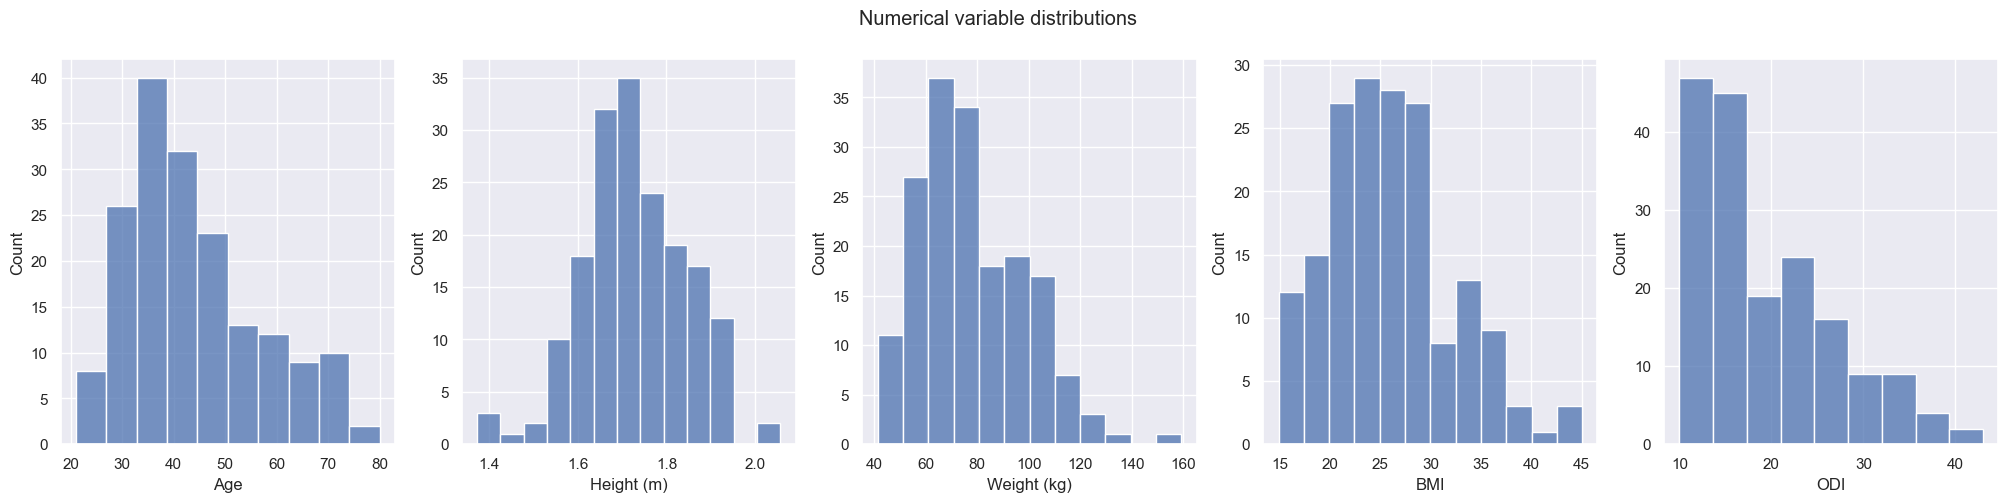

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
sns.histplot(odi_quality_df['age'], ax=axes[0])
sns.histplot(odi_quality_df['height_m'], ax=axes[1])
sns.histplot(odi_quality_df['weight_kg'], ax=axes[2])
sns.histplot(odi_quality_df['bmi'], ax=axes[3])
sns.histplot(odi_quality_df['odi_score'], ax=axes[4])
plt.suptitle("Numerical variable distributions")
axes[0].set_xlabel("Age")
axes[1].set_xlabel("Height (m)")
axes[2].set_xlabel("Weight (kg)")
axes[3].set_xlabel("BMI")
axes[4].set_xlabel("ODI")
plt.show()

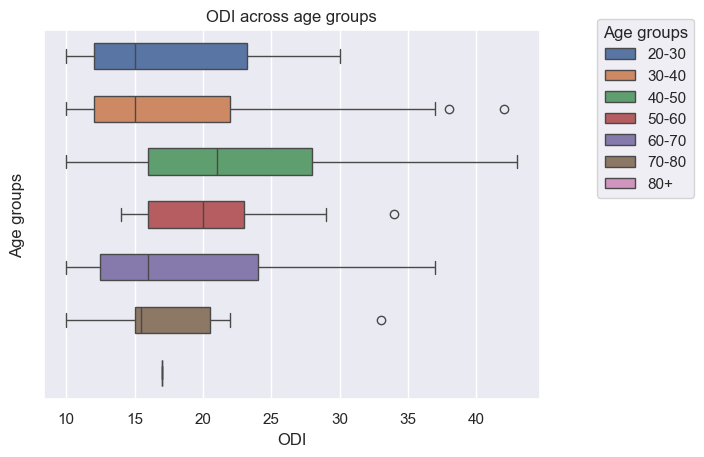

In [32]:
sns.boxplot(odi_quality_df.sort_values('age_range'), x='odi_score', hue='age_range', width=1, gap=0.5)
plt.title("ODI across age groups")
plt.legend(title="Age groups", bbox_to_anchor=(1.1, 1.05))
plt.ylabel("Age groups")
plt.xlabel("ODI")
plt.show()

/var/folders/4f/fzllrn4502l9flldxbwxtf9m0000gn/T/ipykernel_48004/3908354730.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=odi_quality_df.sort_values('age_range'), x='odi_score', hue='age_range')


<Axes: xlabel='odi_score', ylabel='Density'>

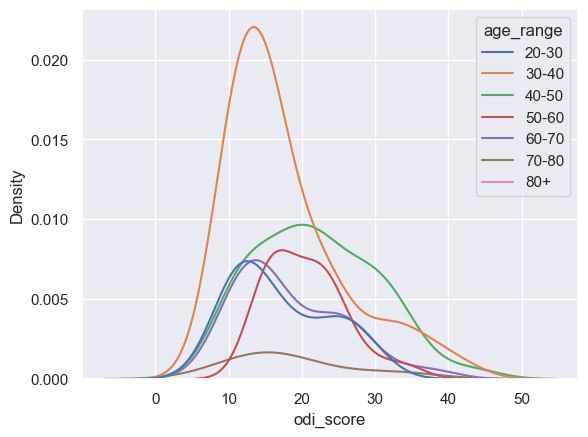

In [18]:
sns.kdeplot(data=odi_quality_df.sort_values('age_range'), x='odi_score', hue='age_range')

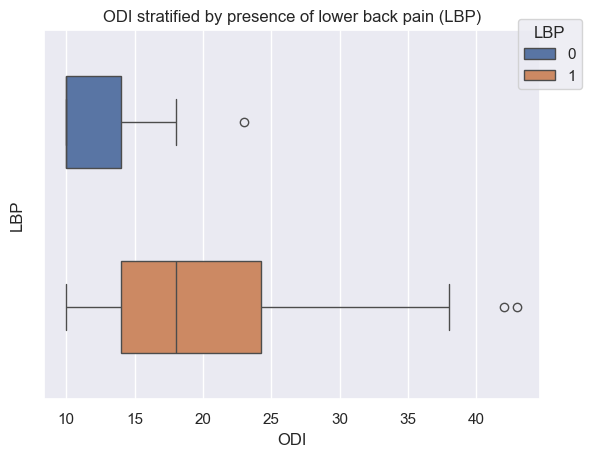

In [33]:
sns.boxplot(odi_quality_df.sort_values('age_range'), x='odi_score', hue='lbp', width=1, gap=0.5)
plt.title("ODI stratified by presence of lower back pain (LBP)")
plt.legend(title="LBP", bbox_to_anchor=(1.1, 1.05))
plt.ylabel("LBP")
plt.xlabel("ODI")
plt.show()

In [37]:
# ODI
nonnormal = ['odi_score']
categorical = ['age_range', 'sex']
columns = nonnormal + categorical
mytable = TableOne(odi_quality_df, columns=columns, categorical=categorical, nonnormal=nonnormal, groupby=['sex'], pval=True)

## Display the table using the tabulate method. The tablefmt argument allows the table to be displayed in multiple formats, including “github”, “grid”, “fancy_grid”, “rst”, “html”, and “latex”.:
print(mytable.tabulate(tablefmt="github"))
# mytable

|                           |       | Missing   | Overall          | 1                | 2                | P-Value   |
|---------------------------|-------|-----------|------------------|------------------|------------------|-----------|
| n                         |       |           | 175              | 68               | 107              |           |
| odi_score, median [Q1,Q3] |       | 0         | 17.0 [13.0,24.0] | 17.0 [12.0,23.0] | 18.0 [13.5,25.0] | 0.358     |
| age_range, n (%)          | 20-30 | 0         | 22 (12.6)        | 7 (10.3)         | 15 (14.0)        | 0.683     |
|                           | 30-40 |           | 61 (34.9)        | 27 (39.7)        | 34 (31.8)        |           |
|                           | 40-50 |           | 41 (23.4)        | 13 (19.1)        | 28 (26.2)        |           |
|                           | 50-60 |           | 21 (12.0)        | 8 (11.8)         | 13 (12.1)        |           |
|                           | 60-70 |           

In [39]:
# ODI
nonnormal = ['odi_score']
categorical = ['age_range', 'sex']
columns = nonnormal + categorical
mytable = TableOne(odi_quality_df, columns=columns, categorical=categorical, nonnormal=nonnormal, groupby=['age_range'], pval=True)

## Display the table using the tabulate method. The tablefmt argument allows the table to be displayed in multiple formats, including “github”, “grid”, “fancy_grid”, “rst”, “html”, and “latex”.:
print(mytable.tabulate(tablefmt="github"))
# mytable.tabulate(tablefmt=)
mytable

|                           |       | Missing   | Overall          | 20-30            | 30-40            | 40-50            | 50-60            | 60-70            | 70-80            | 80+              | P-Value   |
|---------------------------|-------|-----------|------------------|------------------|------------------|------------------|------------------|------------------|------------------|------------------|-----------|
| n                         |       |           | 175              | 22               | 61               | 41               | 21               | 23               | 6                | 1                |           |
| odi_score, median [Q1,Q3] |       | 0         | 17.0 [13.0,24.0] | 15.0 [12.0,23.2] | 15.0 [12.0,22.0] | 21.0 [16.0,28.0] | 20.0 [16.0,23.0] | 16.0 [12.5,24.0] | 15.5 [15.0,20.5] | 17.0 [17.0,17.0] | 0.042     |
| age_range, n (%)          | 20-30 | 0         | 22 (12.6)        | 22 (100.0)       |                  |                  |                  |

Grouped by age_range                                                                                                                                                        
                                             Missing           Overall             20-30             30-40             40-50             50-60             60-70             70-80               80+ P-Value
n                                                                  175                22                61                41                21                23                 6                 1        
odi_score, median [Q1,Q3]                          0  17.0 [13.0,24.0]  15.0 [12.0,23.2]  15.0 [12.0,22.0]  21.0 [16.0,28.0]  20.0 [16.0,23.0]  16.0 [12.5,24.0]  15.5 [15.0,20.5]  17.0 [17.0,17.0]   0.042
age_range, n (%)          20-30                    0         22 (12.6)        22 (100.0)                                                                                                              <0.001
                          30-40                              61 (34.9)                          61 (100.0)                                                                                                  
                          40-50                              41 (23.4)                                            41 (100.0)                                                                                
                          50-60                              21 (12.0)                                                              21 (100.0)                                                              
                          60-70                              23 (13.1)                                                                                23 (100.0)                                            
                          70-80                                6 (3.4)                                                                                                   6 (100.0)                          
                          80+                                  1 (0.6)                                                                                                                     1 (100.0)        
sex, n (%)                1                        0         68 (38.9)          7 (31.8)         27 (44.3)         13 (31.7)          8 (38.1)         10 (43.5)          2 (33.3)         1 (100.0)   0.683
                          2                                 107 (61.1)         15 (68.2)         34 (55.7)         28 (68.3)         13 (61.9)         13 (56.5)          4 (66.7)                          
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: age_range, sex.